Comparing climatology methods across single decade, dual decade and three decade 

--- all for single day climo ---

In [1]:
%matplotlib inline

import xarray as xr
import numpy as np
import os as os
import matplotlib.pyplot as plt
from cartopy import config
import cartopy.crs as ccrs
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import pandas as pd
import itertools
import datetime 
import toolz
from datetime import date
from pathlib import Path, PurePath

import sys

import dask.distributed as dd
import dask_kubernetes as dk
import dask
import rhg_compute_tools.kubernetes as rhgk

In [2]:
client, cluster = rhgk.get_standard_cluster()
cluster.scale(10)

In [3]:
client

Client Scheduler: gateway://traefik-impactlab-hub-dask-gateway.impactlab-hub:80/impactlab-hub.afd557bfd6b04883a378a6cbd7ddd43e Dashboard: /services/dask-gateway/clusters/impactlab-hub.afd557bfd6b04883a378a6cbd7ddd43e/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [1]:
cluster.close()

NameError: name 'cluster' is not defined

 Define variables for comparison

In [4]:
# create list of start and end years for rolling mean climo decade calculations

start_years = [1980,1990,2000,2010]
end_years = [1989,1999,2009,2018]

yr_index = 0

In [5]:
# Climatology start times

start_time_climo = ["1980-01-01","1990-01-01","2000-01-01","2010-01-01"]
end_time_climo = ["1989-12-31","1999-12-31","2009-12-31","2018-12-31"]

thirtyyr_period_1980_2009 = ["1980-01-01","2009-12-31"]
thirtyyr_period_1989_2018 = ["1989-01-01","2018-12-31"]

In [6]:
# Latitude and longitude of 4 US cities of interest
# 1. San Diego, CA
# 2. Boise, ID
# 3. Atlanta, GA
# 4. St. Louis, MO

lat = [32.7, 43.6, 33.75, 38.6]
long = [243, 244, 276.39, 270.2]

Start analysis of ERA5 data to gather, compute and save climatologies

In [7]:
# Per decade analysis
filenames = []

yrs = [*range(start_years[0],end_years[3]+1,1)] 
    
for num_yrs in range(len(yrs)):
    filename = '/gcs/impactlab-data/climate/source_data/ERA-5/day/tas/v1.0/tas_daily_{}-{}.nc'.format(yrs[num_yrs], yrs[num_yrs])
    filenames.append(filename)

# To check correct files, uncomment two lines below.

#    if num_yrs == len(yrs)-1:
#        print(filenames)

In [20]:
# ! ls /gcs/impactlab-data/climate/source_data/ERA-5/day/tas/v1.0/

intermediate		tas_daily_1992-1992.nc	tas_daily_2006-2006.nc
tas_daily_1979-1979.nc	tas_daily_1993-1993.nc	tas_daily_2007-2007.nc
tas_daily_1980-1980.nc	tas_daily_1994-1994.nc	tas_daily_2008-2008.nc
tas_daily_1981-1981.nc	tas_daily_1995-1995.nc	tas_daily_2009-2009.nc
tas_daily_1982-1982.nc	tas_daily_1996-1996.nc	tas_daily_2010-2010.nc
tas_daily_1983-1983.nc	tas_daily_1997-1997.nc	tas_daily_2011-2011.nc
tas_daily_1984-1984.nc	tas_daily_1998-1998.nc	tas_daily_2012-2012.nc
tas_daily_1985-1985.nc	tas_daily_1999-1999.nc	tas_daily_2013-2013.nc
tas_daily_1986-1986.nc	tas_daily_2000-2000.nc	tas_daily_2014-2014.nc
tas_daily_1987-1987.nc	tas_daily_2001-2001.nc	tas_daily_2015-2015.nc
tas_daily_1988-1988.nc	tas_daily_2002-2002.nc	tas_daily_2016-2016.nc
tas_daily_1989-1989.nc	tas_daily_2003-2003.nc	tas_daily_2017-2017.nc
tas_daily_1990-1990.nc	tas_daily_2004-2004.nc	tas_daily_2018-2018.nc
tas_daily_1991-1991.nc	tas_daily_2005-2005.nc


In [8]:
era5_tas = xr.open_mfdataset(filenames, 
                               concat_dim='time', combine='by_coords')
print('Loading ERA5 files...')
# print(era5_tas['tas'])

Loading ERA5 files...


In [9]:
# Pull out leap days
tas_all = era5_tas['tas']

tas_noleap_all = tas_all.where(~((tas_all.time.dt.month == 2) & (tas_all.time.dt.day == 29)), drop=True)

/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [10]:
# Change dayofyear to remove day 366 (leap day index)
tas_noleap_all = tas_noleap_all.assign_coords(dayofyear=xr.DataArray(np.array([np.arange(1,366)]*len(yrs)).flatten(),
                                                dims=('time'),
                                                coords={'time':tas_noleap_all.time}))
# tas_noleap_all

In [11]:
tas_noleap_all.nbytes / (1024**3)

55.057355761528015

In [12]:
tas_noleap_all.persist()

<xarray.DataArray 'tas' (time: 14235, latitude: 721, longitude: 1440)>
dask.array<where, shape=(14235, 721, 1440), dtype=float32, chunksize=(365, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * time       (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2018-12-31
    dayofyear  (time) int64 1 2 3 4 5 6 7 8 ... 358 359 360 361 362 363 364 365
Attributes:
    author:   Diana Gergel
    contact:  dgergel@rhg.com
    project:  historical-climate-data-diagnostics
    source:   era5_hourly_reanalysis_single_levels_sa from Pangeo Datastore, ...
    method:   mean of tas
    units:    K

Calculation of Climatology (mean) per City!

In [13]:
# Loop through decade based climatology calculation, save per decade @ each US city

# Create list of lists to save decade based climatology
SD_climo = [[] for i in range(0,len(start_years))]
BI_climo = [[] for i in range(0,len(start_years))]
AT_climo = [[] for i in range(0,len(start_years))]
SL_climo = [[] for i in range(0,len(start_years))]

for yr_index in range(0,len(start_years)):
    
    # 'Lazy' Calculate climatology 
    singleclimo_mean = tas_noleap_all.sel(time=slice(start_time_climo[yr_index], end_time_climo[yr_index])).groupby("dayofyear").mean()
    
    # Single day climatologies for 4 US cities
    singleclimo_mean_SD = singleclimo_mean.sel(latitude=lat[0], longitude=long[0], method='nearest').compute()
    singleclimo_mean_BI = singleclimo_mean.sel(latitude=lat[1], longitude=long[1], method='nearest').compute()
    singleclimo_mean_AT = singleclimo_mean.sel(latitude=lat[2], longitude=long[2], method='nearest').compute()
    singleclimo_mean_SL = singleclimo_mean.sel(latitude=lat[3], longitude=long[3], method='nearest').compute()
    
    # Append each decade
    SD_climo[yr_index].append(singleclimo_mean_SD)
    BI_climo[yr_index].append(singleclimo_mean_BI)
    AT_climo[yr_index].append(singleclimo_mean_AT)
    SL_climo[yr_index].append(singleclimo_mean_SL)

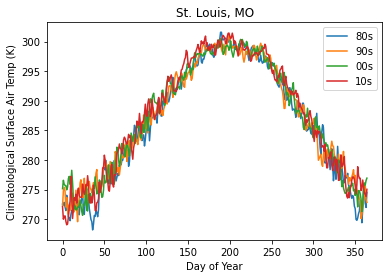

In [14]:
# Plot of St. Louis, MO decade periods

x = range(0,365,1)

fig,ax = plt.subplots()

ax.plot(x, np.squeeze(SL_climo[0]), label='80s') # single day climo
ax.plot(x, np.squeeze(SL_climo[1]), label='90s')
ax.plot(x, np.squeeze(SL_climo[2]), label='00s')
ax.plot(x, np.squeeze(SL_climo[3]), label='10s')

plt.ylabel("Climatological Surface Air Temp (K)")
plt.xlabel("Day of Year")
plt.title("St. Louis, MO")

leg = ax.legend();

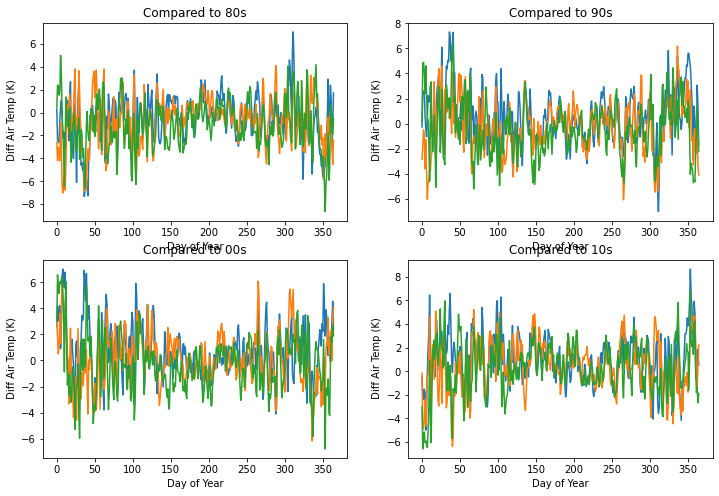

In [15]:
# Single decade diff plot

diff_80s_90s = np.array(SL_climo[0])-np.array(SL_climo[1])
diff_80s_00s = np.array(SL_climo[0])-np.array(SL_climo[2])
diff_80s_10s = np.array(SL_climo[0])-np.array(SL_climo[3])

diff_90s_80s = np.array(SL_climo[1])-np.array(SL_climo[0])
diff_90s_00s = np.array(SL_climo[1])-np.array(SL_climo[2])
diff_90s_10s = np.array(SL_climo[1])-np.array(SL_climo[3])

diff_00s_80s = np.array(SL_climo[2])-np.array(SL_climo[0])
diff_00s_90s = np.array(SL_climo[2])-np.array(SL_climo[1])
diff_00s_10s = np.array(SL_climo[2])-np.array(SL_climo[3])

diff_10s_80s = np.array(SL_climo[3])-np.array(SL_climo[0])
diff_10s_90s = np.array(SL_climo[3])-np.array(SL_climo[1])
diff_10s_00s = np.array(SL_climo[3])-np.array(SL_climo[2])

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs[0, 0].plot(x, np.squeeze(diff_80s_90s))
axs[0, 0].plot(x, np.squeeze(diff_80s_00s))
axs[0, 0].plot(x, np.squeeze(diff_80s_10s))
axs[0, 0].set_title('Compared to 80s')

axs[0, 1].plot(x, np.squeeze(diff_90s_80s))
axs[0, 1].plot(x, np.squeeze(diff_90s_00s))
axs[0, 1].plot(x, np.squeeze(diff_90s_10s))
axs[0, 1].set_title('Compared to 90s')

axs[1, 0].plot(x, np.squeeze(diff_00s_80s))
axs[1, 0].plot(x, np.squeeze(diff_00s_90s))
axs[1, 0].plot(x, np.squeeze(diff_00s_10s))
axs[1, 0].set_title('Compared to 00s')

axs[1, 1].plot(x, np.squeeze(diff_10s_80s))
axs[1, 1].plot(x, np.squeeze(diff_10s_90s))
axs[1, 1].plot(x, np.squeeze(diff_10s_00s))
axs[1, 1].set_title('Compared to 10s')

for ax in axs.flat:
    ax.set(xlabel='Day of Year', ylabel=' Diff Air Temp (K)')


In [16]:
twodecade80s90s_SL_climo = (np.array(SL_climo[0]) + np.array(SL_climo[1])) / 2.0
twodecade90s00s_SL_climo = (np.array(SL_climo[1]) + np.array(SL_climo[2])) / 2.0
twodecade00s10s_SL_climo = (np.array(SL_climo[2]) + np.array(SL_climo[3])) / 2.0

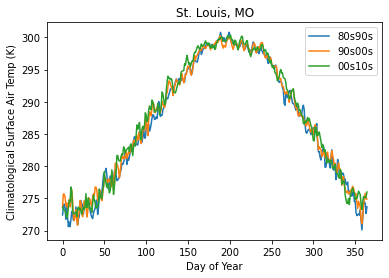

In [17]:
# Plot of St. Louis, MO two-decade periods

x = range(0,365,1)

fig,ax = plt.subplots()

ax.plot(x, np.squeeze(twodecade80s90s_SL_climo), label='80s90s') # single day climo
ax.plot(x, np.squeeze(twodecade90s00s_SL_climo), label='90s00s')
ax.plot(x, np.squeeze(twodecade00s10s_SL_climo), label='00s10s')

plt.ylabel("Climatological Surface Air Temp (K)")
plt.xlabel("Day of Year")
plt.title("St. Louis, MO")

leg = ax.legend();

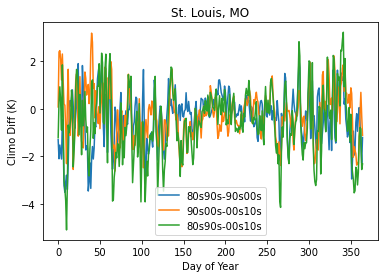

In [18]:
# Two decade diff plots

decade_diff_80s90s = twodecade80s90s_SL_climo - twodecade90s00s_SL_climo
decade_diff_90s00s = twodecade90s00s_SL_climo - twodecade00s10s_SL_climo
decade_diff_80s10s = twodecade80s90s_SL_climo - twodecade00s10s_SL_climo

fig,ax = plt.subplots()

ax.plot(x, np.squeeze(decade_diff_80s90s), label='80s90s-90s00s') # single day climo
ax.plot(x, np.squeeze(decade_diff_90s00s), label='90s00s-00s10s')
ax.plot(x, np.squeeze(decade_diff_80s10s), label='80s90s-00s10s')

plt.ylabel("Climo Diff (K)")
plt.xlabel("Day of Year")
plt.title("St. Louis, MO")

leg = ax.legend();

In [19]:
# Single day climatology 30-yr calculation

threedecade80s90s00s_SL_climo = (np.array(SL_climo[0]) + np.array(SL_climo[1]) + np.array(SL_climo[2])) / 3.0
threedecade90s00s10s_SL_climo = (np.array(SL_climo[1]) + np.array(SL_climo[2]) + np.array(SL_climo[3])) / 3.0

threedecade80s90s00s_SD_climo = (np.array(SD_climo[0]) + np.array(SD_climo[1]) + np.array(SD_climo[2])) / 3.0
threedecade90s00s10s_SD_climo = (np.array(SD_climo[1]) + np.array(SD_climo[2]) + np.array(SD_climo[3])) / 3.0

threedecade80s90s00s_AT_climo = (np.array(AT_climo[0]) + np.array(AT_climo[1]) + np.array(AT_climo[2])) / 3.0
threedecade90s00s10s_AT_climo = (np.array(AT_climo[1]) + np.array(AT_climo[2]) + np.array(AT_climo[3])) / 3.0

threedecade80s90s00s_BI_climo = (np.array(BI_climo[0]) + np.array(BI_climo[1]) + np.array(BI_climo[2])) / 3.0
threedecade90s00s10s_BI_climo = (np.array(BI_climo[1]) + np.array(BI_climo[2]) + np.array(BI_climo[3])) / 3.0

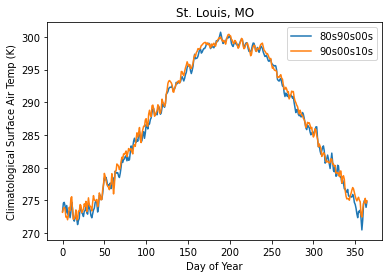

In [20]:
# Plot of St. Louis, MO two-decade periods

x = range(0,365,1)

fig,ax = plt.subplots()

ax.plot(x, np.squeeze(threedecade80s90s00s_SL_climo), label='80s90s00s') # single day climo
ax.plot(x, np.squeeze(threedecade90s00s10s_SL_climo), label='90s00s10s')

plt.ylabel("Climatological Surface Air Temp (K)")
plt.xlabel("Day of Year")
plt.title("St. Louis, MO")

leg = ax.legend();

Text(0.5, 1.0, 'St. Louis, MO -- (80s-00s m 90s-10s) ')

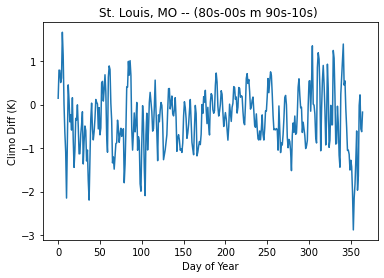

In [21]:
# Difference plots 

threedecade_diff = threedecade80s90s00s_SL_climo - threedecade90s00s10s_SL_climo


fig,ax = plt.subplots()

ax.plot(x, np.squeeze(threedecade_diff))

plt.ylabel("Climo Diff (K)")
plt.xlabel("Day of Year")
plt.title("St. Louis, MO -- (80s-00s m 90s-10s) ")


In [22]:
# Calculation of 1989-1999 for 30-yr period of 1989-2018

singleclimo_mean_extra = tas_noleap_all.sel(time=slice('1989-01-01', '1999-12-31')).groupby("dayofyear").mean()
    
# Single day climatologies for 4 US cities
singleclimo_mean_SD_extra = singleclimo_mean_extra.sel(latitude=lat[0], longitude=long[0], method='nearest').compute()
singleclimo_mean_BI_extra = singleclimo_mean_extra.sel(latitude=lat[1], longitude=long[1], method='nearest').compute()
singleclimo_mean_AT_extra = singleclimo_mean_extra.sel(latitude=lat[2], longitude=long[2], method='nearest').compute()
singleclimo_mean_SL_extra = singleclimo_mean_extra.sel(latitude=lat[3], longitude=long[3], method='nearest').compute()

In [23]:
max(singleclimo_mean_AT_extra)

<xarray.DataArray 'tas' ()>
array(300.49677, dtype=float32)
Coordinates:
    latitude   float32 33.75
    longitude  float32 276.5
    dayofyear  int64 191

**--- Calculation of rolling mean and low pass filter ---**

In [24]:
# 21-day running mean calculation
climo_21runningmean_AT = [[] for i in range(0,4)]
climo_21runningmean_BI = [[] for i in range(0,4)]
climo_21runningmean_SL = [[] for i in range(0,4)]
climo_21runningmean_SD = [[] for i in range(0,4)]

climo_21runningmean_SL_ex = []
climo_21runningmean_SD_ex = []
climo_21runningmean_AT_ex = []
climo_21runningmean_BI_ex = []

# For each decade, ...
for i_dec in range(0,4):

    # For each day, ...
    for i_day in range(0,365):

        if i_day < 10:
            index1 = np.arange(365-(10-i_day),365)
            index2 = np.arange(0,i_day+11)
            index = np.concatenate((index1,index2))

        elif i_day > 354:
            index1 = np.arange(i_day-10,365)
            index2 = np.arange(0,11-(365-i_day))
            index = np.concatenate((index1,index2))

        else:
            index = np.arange(i_day-10,i_day+11)

        # per decade year climo, 21-day index & average then append to per decade date
        climo_SL = np.squeeze(SL_climo[i_dec])
        days21_SL = climo_SL[index].mean()
        climo_21runningmean_SL[i_dec].append(days21_SL)

        climo_AT = np.squeeze(AT_climo[i_dec])
        days21_AT = climo_AT[index].mean()
        climo_21runningmean_AT[i_dec].append(days21_AT)
    
        climo_BI = np.squeeze(BI_climo[i_dec])
        days21_BI = climo_BI[index].mean()
        climo_21runningmean_BI[i_dec].append(days21_BI)    
    
        climo_SD = np.squeeze(SD_climo[i_dec])
        days21_SD = climo_SD[index].mean()
        climo_21runningmean_SD[i_dec].append(days21_SD)
        
        if i_dec == 0:
            
            # Need to also repeat this for the special decade from 1989-1999
            days21_SL_ex = singleclimo_mean_SL_extra[index].mean()
            climo_21runningmean_SL_ex.append(days21_SL_ex)

            days21_SD_ex = singleclimo_mean_SD_extra[index].mean()
            climo_21runningmean_SD_ex.append(days21_SD_ex)
            
            #print(index)
            days21_AT_ex = singleclimo_mean_AT_extra[index].mean()
            #print(days21_AT_ex)
            climo_21runningmean_AT_ex.append(days21_AT_ex)

            days21_BI_ex = singleclimo_mean_BI_extra[index].mean()
            climo_21runningmean_BI_ex.append(days21_BI_ex)

climo_21runningmean_AT_ex = xr.DataArray(climo_21runningmean_AT_ex)
climo_21runningmean_BI_ex = xr.DataArray(climo_21runningmean_BI_ex)
climo_21runningmean_SL_ex = xr.DataArray(climo_21runningmean_SL_ex)
climo_21runningmean_SD_ex = xr.DataArray(climo_21runningmean_SD_ex)

In [81]:
climo_21runningmean_AT_ex

<xarray.DataArray (dim_0: 365)>
array([279.87872, 279.89984, 279.94913, 280.04672, 280.18765, 280.30048,
       280.3187 , 280.4115 , 280.34552, 280.2236 , 280.14252, 280.09207,
       280.12543, 280.1403 , 280.12036, 280.07666, 280.0526 , 280.00037,
       280.111  , 280.2363 , 280.35434, 280.43652, 280.49832, 280.55856,
       280.63342, 280.6876 , 280.7264 , 280.90372, 280.9734 , 281.10187,
       281.28647, 281.42377, 281.5002 , 281.45   , 281.44058, 281.52444,
       281.66397, 281.69635, 281.63052, 281.58923, 281.7154 , 281.8946 ,
       282.0907 , 282.17758, 282.1416 , 282.10785, 282.21188, 282.37195,
       282.51   , 282.62094, 282.7395 , 282.84653, 282.86874, 283.024  ,
       283.28998, 283.47406, 283.5524 , 283.5369 , 283.61594, 283.66428,
       283.689  , 283.6473 , 283.6245 , 283.695  , 283.77448, 283.9318 ,
       284.18658, 284.37717, 284.4346 , 284.44247, 284.52878, 284.64932,
       284.78854, 285.0064 , 285.14163, 285.23355, 285.34265, 285.56772,
       285.8228 , 286.0101 , 286.24066, 286.40475, 286.54303, 286.732  ,
       286.86304, 286.97604, 287.0829 , 287.13147, 287.27042, 287.4647 ,
       287.64453, 287.8256 , 287.94107, 288.03027, 288.1973 , 288.33432,
       288.4673 , 288.57483, 288.6846 , 288.84888, 289.03513, 289.23502,
       289.45303, 289.65247, 289.77737, 289.9135 , 290.0859 , 290.27115,
       290.40933, 290.4816 , 290.64124, 290.7711 , 290.86487, 290.9982 ,
       291.14853, 291.17737, 291.2102 , 291.26468, 291.4053 , 291.5423 ,
...
       296.78717, 296.64304, 296.492  , 296.27652, 296.01944, 295.78064,
       295.60684, 295.43967, 295.20624, 294.9608 , 294.69833, 294.46298,
       294.24414, 294.05612, 293.86734, 293.6764 , 293.4239 , 293.14807,
       292.90045, 292.6848 , 292.46198, 292.24838, 291.9863 , 291.75955,
       291.63623, 291.5685 , 291.49454, 291.38745, 291.21436, 291.00043,
       290.7647 , 290.59918, 290.44046, 290.23325, 289.9715 , 289.74976,
       289.54105, 289.37036, 289.21964, 289.01663, 288.86682, 288.7709 ,
       288.65033, 288.51254, 288.27728, 287.94803, 287.68723, 287.42212,
       287.14603, 286.8784 , 286.6613 , 286.47015, 286.28845, 286.06616,
       285.9031 , 285.7853 , 285.65698, 285.46704, 285.25955, 285.02454,
       284.8986 , 284.77155, 284.65967, 284.555  , 284.42352, 284.32913,
       284.30536, 284.27313, 284.22348, 284.22552, 284.16962, 284.09903,
       284.0596 , 283.99597, 283.9908 , 283.95792, 283.86957, 283.70154,
       283.6093 , 283.48932, 283.39435, 283.23355, 283.0206 , 282.7624 ,
       282.5778 , 282.46686, 282.3315 , 282.20312, 282.03647, 281.90073,
       281.66214, 281.46875, 281.32248, 281.17328, 281.04254, 280.80902,
       280.47205, 280.2076 , 280.04068, 279.87195, 279.8404 , 279.83575,
       279.84464, 279.83914, 279.83215, 279.8245 , 279.77066, 279.80038,
       279.8337 , 279.9631 , 279.97745, 279.9578 , 279.92136],
      dtype=float32)
Dimensions without coordinates: dim_0

In [25]:
# 31-day running mean calculation
climo_31runningmean_AT = [[] for i in range(0,4)]
climo_31runningmean_BI = [[] for i in range(0,4)]
climo_31runningmean_SL = [[] for i in range(0,4)]
climo_31runningmean_SD = [[] for i in range(0,4)]

climo_31runningmean_SL_ex = []
climo_31runningmean_SD_ex = []
climo_31runningmean_AT_ex = []
climo_31runningmean_BI_ex = []

# For each decade, ...
for i_dec in range(0,4):

    # For each day, ...
    for i_day in range(0,365):

        if i_day < 10:
            index1 = np.arange(365-(15-i_day),365)
            index2 = np.arange(0,i_day+16)
            index = np.concatenate((index1,index2))

        elif i_day > 348:
            index1 = np.arange(i_day-15,365)
            index2 = np.arange(0,16-(365-i_day))
            index = np.concatenate((index1,index2))

        else:
            index = np.arange(i_day-15,i_day+16)
            
        # per decade year climo, 31-day index & average then append to per decade date
        climo_SL = np.squeeze(SL_climo[i_dec])
        days31_SL = climo_SL[index].mean()
        climo_31runningmean_SL[i_dec].append(days31_SL) 

        climo_AT = np.squeeze(AT_climo[i_dec])
        days31_AT = climo_AT[index].mean()
        climo_31runningmean_AT[i_dec].append(days31_AT)

        climo_BI = np.squeeze(BI_climo[i_dec])
        days31_BI = climo_BI[index].mean()
        climo_31runningmean_BI[i_dec].append(days31_BI)    

        climo_SD = np.squeeze(SD_climo[i_dec])
        days31_SD = climo_SD[index].mean()
        climo_31runningmean_SD[i_dec].append(days31_SD)
        
        if i_dec == 0:
            # Need to also repeat this for the special decade from 1989-1999
            days31_SL_ex = singleclimo_mean_SL_extra[index].mean()
            climo_31runningmean_SL_ex.append(days31_SL_ex)

            days31_SD_ex = singleclimo_mean_SD_extra[index].mean()
            climo_31runningmean_SD_ex.append(days31_SD_ex)

            days31_AT_ex = singleclimo_mean_AT_extra[index].mean()
            climo_31runningmean_AT_ex.append(days31_AT_ex)

            days31_BI_ex = singleclimo_mean_BI_extra[index].mean()
            climo_31runningmean_BI_ex.append(days31_BI_ex)
    
climo_31runningmean_AT_ex = xr.DataArray(climo_31runningmean_AT_ex)
climo_31runningmean_BI_ex = xr.DataArray(climo_31runningmean_BI_ex)
climo_31runningmean_SL_ex = xr.DataArray(climo_31runningmean_SL_ex)
climo_31runningmean_SD_ex = xr.DataArray(climo_31runningmean_SD_ex)

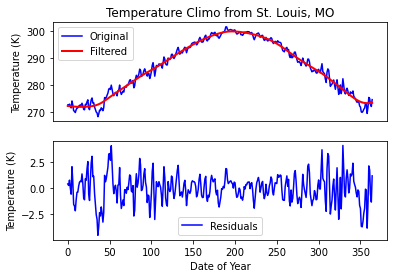

In [26]:
# Lowpass Filter calculation
climo_lowpass_AT = [[] for i in range(0,4)]
climo_lowpass_BI = [[] for i in range(0,4)]
climo_lowpass_SL = [[] for i in range(0,4)]
climo_lowpass_SLv2 = [[] for i in range(0,4)]
climo_lowpass_SD = [[] for i in range(0,4)]

x = range(0,365,1)

import scipy.signal as signal

# First, design the Buterworth filter
N  = 2    # Filter order
Wn = (1/31)   # Cutoff frequency --> time step (daily) / desired filter length (days)
B, A = signal.butter(N, Wn, output='ba')

for i_dec in range(0,4):

    # Second, apply the filter
    temp_SL = signal.filtfilt(B,A, SL_climo[i_dec], padtype='constant', padlen=60, method='pad')
    climo_lowpass_SL[i_dec].append(temp_SL)
    
    temp_SD = signal.filtfilt(B,A, SD_climo[i_dec], padtype='constant', padlen=60, method='pad')
    climo_lowpass_SD[i_dec].append(temp_SD)
    
    temp_AT = signal.filtfilt(B,A, AT_climo[i_dec], padtype='constant', padlen=60, method='pad')
    climo_lowpass_AT[i_dec].append(temp_AT)
    
    temp_BI = signal.filtfilt(B,A, BI_climo[i_dec], padtype='constant', padlen=60, method='pad')
    climo_lowpass_BI[i_dec].append(temp_BI)

# Filter the extra decade variable
climo_lowpass_SL_8990 = signal.filtfilt(B,A, singleclimo_mean_SL_extra, padtype='constant', padlen=60, method='pad')
climo_lowpass_SD_8990 = signal.filtfilt(B,A, singleclimo_mean_SD_extra, padtype='constant', padlen=60, method='pad')
climo_lowpass_AT_8990 = signal.filtfilt(B,A, singleclimo_mean_AT_extra, padtype='constant', padlen=60, method='pad')
climo_lowpass_BI_8990 = signal.filtfilt(B,A, singleclimo_mean_BI_extra, padtype='constant', padlen=60, method='pad')
    
# Make plots
fig = plt.figure()
ax1 = fig.add_subplot(211)
plt.plot(x,np.squeeze(SL_climo[0]), 'b-')
plt.plot(x,np.squeeze(climo_lowpass_SL[0]), 'r-',linewidth=2)
plt.ylabel("Temperature (K)")
plt.legend(['Original','Filtered'])
plt.title("Temperature Climo from St. Louis, MO")
ax1.axes.get_xaxis().set_visible(False)
 
ax1 = fig.add_subplot(212)
plt.plot(x,np.squeeze(SL_climo[0])-np.squeeze(climo_lowpass_SL[0]), 'b-')
plt.ylabel("Temperature (K)")
plt.xlabel("Date of Year")
plt.legend(['Residuals'])

**** testing low pass filter sensitivities ****

In [27]:
z, p, k = signal.tf2zpk(B, A)
eps = 1e-9
r = np.max(np.abs(p))
approx_impulse_len = int(np.ceil(np.log(eps) / np.log(r)))
approx_impulse_len

290

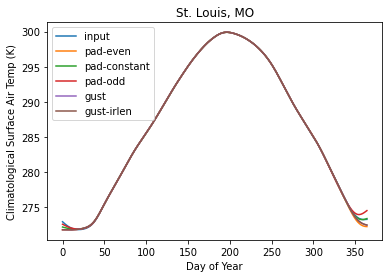

In [28]:
temp_SL = signal.filtfilt(B,A, SL_climo[0]) # padtype='odd', padlen=20, method='pad'
    
temp_SLv2 = signal.filtfilt(B,A, SL_climo[0], padtype='even', padlen=60, method='pad') # 

temp_SLv3 = signal.filtfilt(B,A, SL_climo[0], padtype='constant', padlen=60, method='pad')

temp_SLv4 = signal.filtfilt(B,A, SL_climo[0], padtype='odd', padlen=60, method='pad')

temp_SLv5 = signal.filtfilt(B,A, SL_climo[0], method='gust')

temp_SLv6 = signal.filtfilt(B,A, SL_climo[0], method='gust', irlen=approx_impulse_len)

fig,ax = plt.subplots()

ax.plot(x, np.squeeze(temp_SL), label='input')
ax.plot(x, np.squeeze(temp_SLv2), label='pad-even') # off on either ends
ax.plot(x, np.squeeze(temp_SLv3), label='pad-constant') # off for beginning -- seems to be best option!!
ax.plot(x, np.squeeze(temp_SLv4), label='pad-odd') # off for both -- better for Atlanta and Boise start
ax.plot(x, np.squeeze(temp_SLv5), label='gust')
ax.plot(x, np.squeeze(temp_SLv6), label='gust-irlen')

plt.ylabel("Climatological Surface Air Temp (K)")
plt.xlabel("Day of Year")
plt.title("St. Louis, MO")

leg = ax.legend();

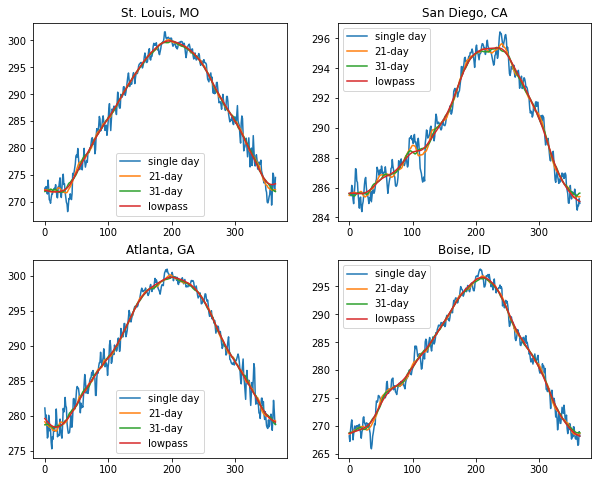

In [29]:
# Plot of climatology methods for 4 US cities
# Rolling means taken after climo calc

# Single decade plot -- 1980s

x = range(0,365,1)

fig,ax = plt.subplots(2,2, figsize=(10, 8))

ax[0,0].plot(x, np.squeeze(SL_climo[0]), label='single day') # single day climo
ax[0,0].plot(x, np.squeeze(climo_21runningmean_SL[0]), label='21-day')
ax[0,0].plot(x, np.squeeze(climo_31runningmean_SL[0]), label='31-day')
ax[0,0].plot(x, np.squeeze(climo_lowpass_SL[0]), label='lowpass')
ax[0,0].set_title('St. Louis, MO')
ax[0,0].legend();

ax[0,1].plot(x, np.squeeze(SD_climo[0]), label='single day') # single day climo
ax[0,1].plot(x, np.squeeze(climo_21runningmean_SD[0]), label='21-day')
ax[0,1].plot(x, np.squeeze(climo_31runningmean_SD[0]), label='31-day')
ax[0,1].plot(x, np.squeeze(climo_lowpass_SD[0]), label='lowpass')
ax[0,1].set_title('San Diego, CA')
ax[0,1].legend();

ax[1,0].plot(x, np.squeeze(AT_climo[0]), label='single day') # single day climo
ax[1,0].plot(x, np.squeeze(climo_21runningmean_AT[0]), label='21-day')
ax[1,0].plot(x, np.squeeze(climo_31runningmean_AT[0]), label='31-day')
ax[1,0].plot(x, np.squeeze(climo_lowpass_AT[0]), label='lowpass')
ax[1,0].set_title('Atlanta, GA')
ax[1,0].legend();

ax[1,1].plot(x, np.squeeze(BI_climo[0]), label='single day') # single day climo
ax[1,1].plot(x, np.squeeze(climo_21runningmean_BI[0]), label='21-day')
ax[1,1].plot(x, np.squeeze(climo_31runningmean_BI[0]), label='31-day')
ax[1,1].plot(x, np.squeeze(climo_lowpass_BI[0]), label='lowpass')
ax[1,1].set_title('Boise, ID')
ax[1,1].legend();

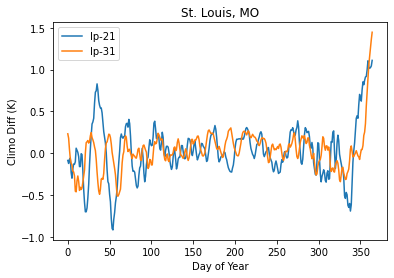

In [30]:
# diff btw lowpass filter and running mean plots over 1980s

diff_lp_21 = np.squeeze(climo_lowpass_SL[0])-np.squeeze(climo_21runningmean_SL[0])
diff_lp_31 = np.squeeze(climo_lowpass_SL[0])-np.squeeze(climo_31runningmean_SL[0])

fig,ax = plt.subplots()

ax.plot(x, np.squeeze(diff_lp_21), label='lp-21') # single day climo
ax.plot(x, np.squeeze(diff_lp_31), label='lp-31')


plt.ylabel("Climo Diff (K)")
plt.xlabel("Day of Year")
plt.title("St. Louis, MO")

leg = ax.legend();

In [31]:
# Calculating 30-yr climos for 4 US cities 
# Period 1: 1980-2009
# Period 2: 1989-2018 -- first variable with '_ex' to incorpate 1989 into 90s avg

# St. Louis
threedecade80s90s00s_SL_climo_21 = (np.array(climo_21runningmean_SL[0]) + np.array(climo_21runningmean_SL[1]) + np.array(climo_21runningmean_SL[2])) / 3.0
threedecade90s00s10s_SL_climo_21 = (np.array(climo_21runningmean_SL_ex) + np.array(climo_21runningmean_SL[2]) + np.array(climo_21runningmean_SL[3])) / 3.0

threedecade80s90s00s_SL_climo_31 = (np.array(climo_31runningmean_SL[0]) + np.array(climo_31runningmean_SL[1]) + np.array(climo_31runningmean_SL[2])) / 3.0
threedecade90s00s10s_SL_climo_31 = (np.array(climo_31runningmean_SL_ex) + np.array(climo_31runningmean_SL[2]) + np.array(climo_31runningmean_SL[3])) / 3.0

threedecade80s90s00s_SL_climo_lp = (np.array(climo_lowpass_SL[0]) + np.array(climo_lowpass_SL[1]) + np.array(climo_lowpass_SL[2])) / 3.0
threedecade90s00s10s_SL_climo_lp = (np.array(climo_lowpass_SL_8990) + np.array(climo_lowpass_SL[2]) + np.array(climo_lowpass_SL[3])) / 3.0

# San Diego
threedecade80s90s00s_SD_climo_21 = (np.array(climo_21runningmean_SD[0]) + np.array(climo_21runningmean_SD[1]) + np.array(climo_21runningmean_SD[2])) / 3.0
threedecade90s00s10s_SD_climo_21 = (np.array(climo_21runningmean_SD_ex) + np.array(climo_21runningmean_SD[2]) + np.array(climo_21runningmean_SD[3])) / 3.0

threedecade80s90s00s_SD_climo_31 = (np.array(climo_31runningmean_SD[0]) + np.array(climo_31runningmean_SD[1]) + np.array(climo_31runningmean_SD[2])) / 3.0
threedecade90s00s10s_SD_climo_31 = (np.array(climo_31runningmean_SD_ex) + np.array(climo_31runningmean_SD[2]) + np.array(climo_31runningmean_SD[3])) / 3.0

threedecade80s90s00s_SD_climo_lp = (np.array(climo_lowpass_SD[0]) + np.array(climo_lowpass_SD[1]) + np.array(climo_lowpass_SD[2])) / 3.0
threedecade90s00s10s_SD_climo_lp = (np.array(climo_lowpass_SD_8990) + np.array(climo_lowpass_SD[2]) + np.array(climo_lowpass_SD[3])) / 3.0

# Atlanta
threedecade80s90s00s_AT_climo_21 = (np.array(climo_21runningmean_AT[0]) + np.array(climo_21runningmean_AT[1]) + np.array(climo_21runningmean_AT[2])) / 3.0
threedecade90s00s10s_AT_climo_21 = (np.array(climo_21runningmean_AT_ex) + np.array(climo_21runningmean_AT[2]) + np.array(climo_21runningmean_AT[3])) / 3.0

threedecade80s90s00s_AT_climo_31 = (np.array(climo_31runningmean_AT[0]) + np.array(climo_31runningmean_AT[1]) + np.array(climo_31runningmean_AT[2])) / 3.0
threedecade90s00s10s_AT_climo_31 = (np.array(climo_31runningmean_AT_ex) + np.array(climo_31runningmean_AT[2]) + np.array(climo_31runningmean_AT[3])) / 3.0

threedecade80s90s00s_AT_climo_lp = (np.array(climo_lowpass_AT[0]) + np.array(climo_lowpass_AT[1]) + np.array(climo_lowpass_AT[2])) / 3.0
threedecade90s00s10s_AT_climo_lp = (np.array(climo_lowpass_AT_8990) + np.array(climo_lowpass_AT[2]) + np.array(climo_lowpass_AT[3])) / 3.0

# Boise
threedecade80s90s00s_BI_climo_21 = (np.array(climo_21runningmean_BI[0]) + np.array(climo_21runningmean_BI[1]) + np.array(climo_21runningmean_BI[2])) / 3.0
threedecade90s00s10s_BI_climo_21 = (np.array(climo_21runningmean_BI_ex) + np.array(climo_21runningmean_BI[2]) + np.array(climo_21runningmean_BI[3])) / 3.0

threedecade80s90s00s_BI_climo_31 = (np.array(climo_31runningmean_BI[0]) + np.array(climo_31runningmean_BI[1]) + np.array(climo_31runningmean_BI[2])) / 3.0
threedecade90s00s10s_BI_climo_31 = (np.array(climo_31runningmean_BI_ex) + np.array(climo_31runningmean_BI[2]) + np.array(climo_31runningmean_BI[3])) / 3.0

threedecade80s90s00s_BI_climo_lp = (np.array(climo_lowpass_BI[0]) + np.array(climo_lowpass_BI[1]) + np.array(climo_lowpass_BI[2])) / 3.0
threedecade90s00s10s_BI_climo_lp = (np.array(climo_lowpass_BI_8990) + np.array(climo_lowpass_BI[2]) + np.array(climo_lowpass_BI[3])) / 3.0


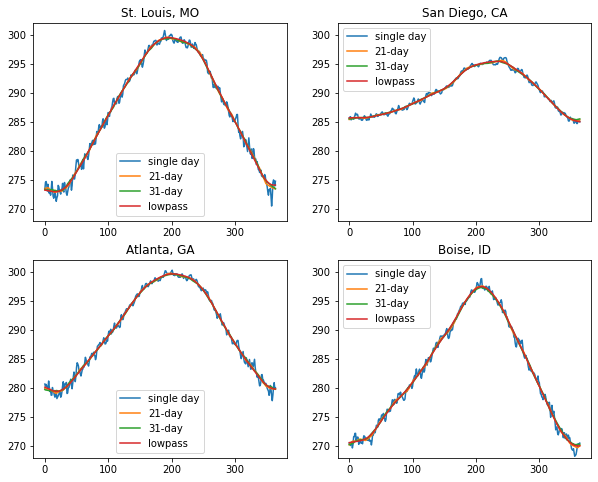

In [32]:
# Plot of climatology methods for 4 US cities
# Rolling means taken after climo calc

# thirty year period

x = range(0,365,1)

fig,ax = plt.subplots(2,2, figsize=(10, 8))

ax[0,0].plot(x, np.squeeze(threedecade80s90s00s_SL_climo), label='single day') # single day climo
ax[0,0].plot(x, np.squeeze(threedecade80s90s00s_SL_climo_21), label='21-day')
ax[0,0].plot(x, np.squeeze(threedecade80s90s00s_SL_climo_31), label='31-day')
ax[0,0].plot(x, np.squeeze(threedecade80s90s00s_SL_climo_lp), label='lowpass')
ax[0,0].set_title('St. Louis, MO')
ax[0,0].set_ylim([268,302])
ax[0,0].legend();

ax[0,1].plot(x, np.squeeze(threedecade80s90s00s_SD_climo), label='single day') # single day climo
ax[0,1].plot(x, np.squeeze(threedecade80s90s00s_SD_climo_21), label='21-day')
ax[0,1].plot(x, np.squeeze(threedecade80s90s00s_SD_climo_31), label='31-day')
ax[0,1].plot(x, np.squeeze(threedecade80s90s00s_SD_climo_lp), label='lowpass')
ax[0,1].set_title('San Diego, CA')
ax[0,1].set_ylim([268,302])
ax[0,1].legend();

ax[1,0].plot(x, np.squeeze(threedecade80s90s00s_AT_climo), label='single day') # single day climo
ax[1,0].plot(x, np.squeeze(threedecade80s90s00s_AT_climo_21), label='21-day')
ax[1,0].plot(x, np.squeeze(threedecade80s90s00s_AT_climo_31), label='31-day')
ax[1,0].plot(x, np.squeeze(threedecade80s90s00s_AT_climo_lp), label='lowpass')
ax[1,0].set_title('Atlanta, GA')
ax[1,0].set_ylim([268,302])
ax[1,0].legend();

ax[1,1].plot(x, np.squeeze(threedecade80s90s00s_BI_climo), label='single day') # single day climo
ax[1,1].plot(x, np.squeeze(threedecade80s90s00s_BI_climo_21), label='21-day')
ax[1,1].plot(x, np.squeeze(threedecade80s90s00s_BI_climo_31), label='31-day')
ax[1,1].plot(x, np.squeeze(threedecade80s90s00s_BI_climo_lp), label='lowpass')
ax[1,1].set_title('Boise, ID')
ax[1,1].set_ylim([268,302])
ax[1,1].legend();

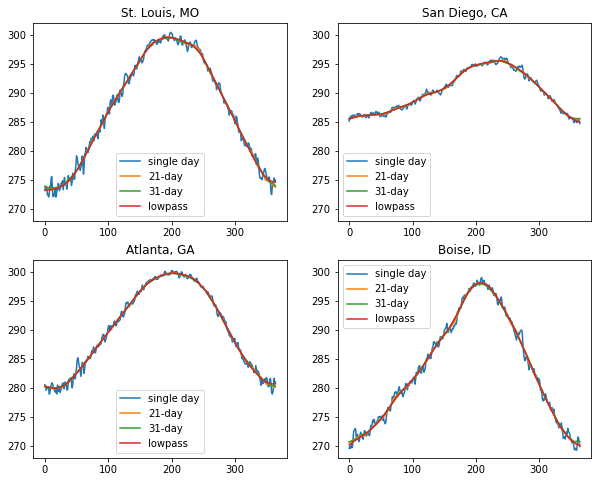

In [33]:
# thirty year period

x = range(0,365,1)

fig,ax = plt.subplots(2,2, figsize=(10, 8))

ax[0,0].plot(x, np.squeeze(threedecade90s00s10s_SL_climo), label='single day') # single day climo
ax[0,0].plot(x, np.squeeze(threedecade90s00s10s_SL_climo_21), label='21-day')
ax[0,0].plot(x, np.squeeze(threedecade90s00s10s_SL_climo_31), label='31-day')
ax[0,0].plot(x, np.squeeze(threedecade90s00s10s_SL_climo_lp), label='lowpass')
ax[0,0].set_title('St. Louis, MO')
ax[0,0].set_ylim([268,302])
ax[0,0].legend();

ax[0,1].plot(x, np.squeeze(threedecade90s00s10s_SD_climo), label='single day') # single day climo
ax[0,1].plot(x, np.squeeze(threedecade90s00s10s_SD_climo_21), label='21-day')
ax[0,1].plot(x, np.squeeze(threedecade90s00s10s_SD_climo_31), label='31-day')
ax[0,1].plot(x, np.squeeze(threedecade90s00s10s_SD_climo_lp), label='lowpass')
ax[0,1].set_title('San Diego, CA')
ax[0,1].set_ylim([268,302])
ax[0,1].legend();

ax[1,0].plot(x, np.squeeze(threedecade90s00s10s_AT_climo), label='single day') # single day climo
ax[1,0].plot(x, np.squeeze(threedecade90s00s10s_AT_climo_21), label='21-day')
ax[1,0].plot(x, np.squeeze(threedecade90s00s10s_AT_climo_31), label='31-day')
ax[1,0].plot(x, np.squeeze(threedecade90s00s10s_AT_climo_lp), label='lowpass')
ax[1,0].set_title('Atlanta, GA')
ax[1,0].set_ylim([268,302])
ax[1,0].legend();

ax[1,1].plot(x, np.squeeze(threedecade90s00s10s_BI_climo), label='single day') # single day climo
ax[1,1].plot(x, np.squeeze(threedecade90s00s10s_BI_climo_21), label='21-day')
ax[1,1].plot(x, np.squeeze(threedecade90s00s10s_BI_climo_31), label='31-day')
ax[1,1].plot(x, np.squeeze(threedecade90s00s10s_BI_climo_lp), label='lowpass')
ax[1,1].set_title('Boise, ID')
ax[1,1].set_ylim([268,302])
ax[1,1].legend();

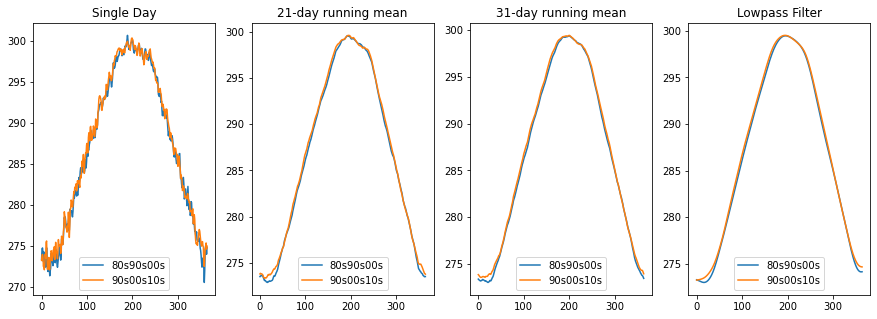

In [34]:
# Plot of St. Louis, MO three-decade periods

x = range(0,365,1)

fig,ax = plt.subplots(1,4, figsize=(15, 5))

ax[0].plot(x, np.squeeze(threedecade80s90s00s_SL_climo), label='80s90s00s')
ax[0].plot(x, np.squeeze(threedecade90s00s10s_SL_climo), label='90s00s10s')
ax[0].set_title('Single Day')
ax[0].legend();

ax[1].plot(x, threedecade80s90s00s_SL_climo_21 , label='80s90s00s') # single day climo
ax[1].plot(x, threedecade90s00s10s_SL_climo_21, label='90s00s10s')
ax[1].set_title('21-day running mean')
ax[1].legend();

ax[2].plot(x, threedecade80s90s00s_SL_climo_31, label='80s90s00s') # single day climo
ax[2].plot(x, threedecade90s00s10s_SL_climo_31, label='90s00s10s')
ax[2].set_title('31-day running mean')
ax[2].legend();

ax[3].plot(x, np.squeeze(threedecade80s90s00s_SL_climo_lp), label='80s90s00s') # single day climo
ax[3].plot(x, np.squeeze(threedecade90s00s10s_SL_climo_lp), label='90s00s10s')
ax[3].set_title('Lowpass Filter')
ax[3].legend();

for ax in axs.flat:
    ax.set(xlabel='Day of Year', ylabel='Climo Air Temp (K)')

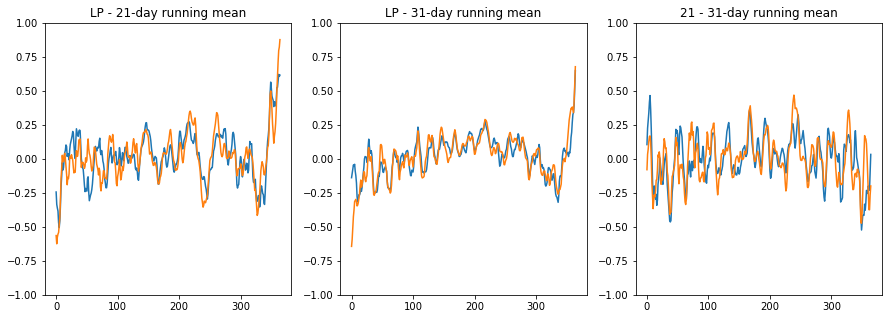

In [35]:
# Plot of St. Louis, MO two-decade periods

lp_21_80s00s = np.squeeze(threedecade80s90s00s_SL_climo_lp) - threedecade80s90s00s_SL_climo_21
lp_21_90s10s = np.squeeze(threedecade90s00s10s_SL_climo_lp) - threedecade90s00s10s_SL_climo_21

lp_31_80s00s = np.squeeze(threedecade80s90s00s_SL_climo_lp) - threedecade80s90s00s_SL_climo_31
lp_31_90s10s = np.squeeze(threedecade90s00s10s_SL_climo_lp) - threedecade90s00s10s_SL_climo_31

diff_21_31_80s00s = threedecade80s90s00s_SL_climo_21 - threedecade80s90s00s_SL_climo_31
diff_21_31_90s10s = threedecade90s00s10s_SL_climo_21 - threedecade90s00s10s_SL_climo_31

x = range(0,365,1)

fig,ax = plt.subplots(1,3, figsize=(15, 5))

ax[0].plot(x, lp_21_80s00s) 
ax[0].plot(x, lp_21_90s10s)
ax[0].set_title('LP - 21-day running mean')
ax[0].set_ylim([-1,1])

ax[1].plot(x, lp_31_80s00s)
ax[1].plot(x, lp_31_90s10s)
ax[1].set_title('LP - 31-day running mean')
ax[1].set_ylim([-1,1])

ax[2].plot(x, diff_21_31_80s00s)
ax[2].plot(x, diff_21_31_90s10s)
ax[2].set_title('21 - 31-day running mean')
ax[2].set_ylim([-1,1])

for ax in axs.flat:
    ax.set(xlabel='Day of Year', ylabel='Climo Air Temp (K)')

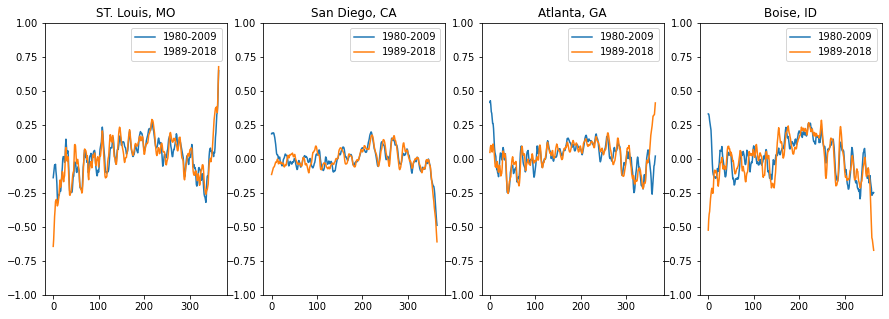

In [36]:
# 30-yr period difference between 31-day running mean and lowpass filter 

lp_31_80s00s_SL = np.squeeze(threedecade80s90s00s_SL_climo_lp) - threedecade80s90s00s_SL_climo_31
lp_31_90s10s_SL = np.squeeze(threedecade90s00s10s_SL_climo_lp) - threedecade90s00s10s_SL_climo_31

lp_31_80s00s_SD = np.squeeze(threedecade80s90s00s_SD_climo_lp) - threedecade80s90s00s_SD_climo_31
lp_31_90s10s_SD = np.squeeze(threedecade90s00s10s_SD_climo_lp) - threedecade90s00s10s_SD_climo_31

lp_31_80s00s_AT = np.squeeze(threedecade80s90s00s_AT_climo_lp) - threedecade80s90s00s_AT_climo_31
lp_31_90s10s_AT = np.squeeze(threedecade90s00s10s_AT_climo_lp) - threedecade90s00s10s_AT_climo_31

lp_31_80s00s_BI = np.squeeze(threedecade80s90s00s_BI_climo_lp) - threedecade80s90s00s_BI_climo_31
lp_31_90s10s_BI = np.squeeze(threedecade90s00s10s_BI_climo_lp) - threedecade90s00s10s_BI_climo_31

fig,ax = plt.subplots(1,4, figsize=(15, 5))

ax[0].plot(x, lp_31_80s00s_SL, label='1980-2009')
ax[0].plot(x, lp_31_90s10s_SL, label='1989-2018')
ax[0].set_title('ST. Louis, MO')
ax[0].set_ylim([-1,1])
ax[0].legend();

ax[1].plot(x, lp_31_80s00s_SD, label='1980-2009') # single day climo
ax[1].plot(x, lp_31_90s10s_SD, label='1989-2018')
ax[1].set_title('San Diego, CA')
ax[1].set_ylim([-1,1])
ax[1].legend();

ax[2].plot(x, lp_31_80s00s_AT, label='1980-2009') # single day climo
ax[2].plot(x, lp_31_90s10s_AT, label='1989-2018')
ax[2].set_title('Atlanta, GA')
ax[2].set_ylim([-1,1])
ax[2].legend();

ax[3].plot(x, lp_31_80s00s_BI, label='1980-2009') # single day climo
ax[3].plot(x, lp_31_90s10s_BI, label='1989-2018')
ax[3].set_title('Boise, ID')
ax[3].set_ylim([-1,1])
ax[3].legend();


--- stop here! test code below. ---

**--- Focus on making CONUS wide maps of difference between methods ---**

--- calculate global 31-day running mean and lowpass filter ---

In [38]:
# Loop through decade based climatology calculation for all grid points

perdecade_climo = [[] for i in range(0,len(start_years))]

for yr_index in range(0,len(start_years)):
    
    # 'Lazy' Calculate climatology 
    singleclimo_mean = tas_noleap_all.sel(time=slice(start_time_climo[yr_index], end_time_climo[yr_index])).groupby("dayofyear").mean().compute()
    climo_withcoords = singleclimo_mean.copy(deep=True, data=singleclimo_mean)
    perdecade_climo[yr_index].append(climo_withcoords)

In [41]:
# Calculation of 1989-1999 for 30-yr period of 1989-2018

singleclimo_1989_1999 = tas_noleap_all.sel(time=slice('1989-01-01', '1999-12-31')).groupby("dayofyear").mean().compute()

In [43]:
# 21 day running mean

climo_21runningmean = [[] for i in range(0,4)]

climo_21runningmean_1989_1999 = []

# For each decade, ...
for i_dec in range(0,4):
    print(i_dec)
    # For each day, ...
    for i_day in range(0,365):
        #print(i_day)

        if i_day < 10:
            index1 = np.arange(365-(10-i_day),365)
            index2 = np.arange(0,i_day+11)
            index = np.concatenate((index1,index2))

        elif i_day > 354:
            index1 = np.arange(i_day-10,365)
            index2 = np.arange(0,11-(365-i_day))
            index = np.concatenate((index1,index2))

        else:
            index = np.arange(i_day-10,i_day+11)

        # per decade year climo, 21-day index & average then append to per decade date
        climo = np.squeeze(perdecade_climo[i_dec])
        days21 = climo[index].mean()
        climo_21runningmean[i_dec].append(days21)
        
        if i_dec == 0:      
            # Need to also repeat this for the special decade from 1989-1999
            days21_ex = singleclimo_1989_1999[index].mean()
            climo_21runningmean_1989_1999.append(days21_ex)

climo_21runningmean_1989_1999 = xr.DataArray(climo_21runningmean_1989_1999)

0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276


In [46]:
# 31-day running mean

climo_31runningmean = [[] for i in range(0,4)]

climo_31runningmean_1989_1999 = []

# For each decade, ...
for i_dec in range(0,4):
    print(i_dec)
    # For each day, ...
    for i_day in range(0,365):

        if i_day < 10:
            index1 = np.arange(365-(15-i_day),365)
            index2 = np.arange(0,i_day+16)
            index = np.concatenate((index1,index2))

        elif i_day > 348:
            index1 = np.arange(i_day-15,365)
            index2 = np.arange(0,16-(365-i_day))
            index = np.concatenate((index1,index2))

        else:
            index = np.arange(i_day-15,i_day+16)
            
        # per decade year climo, 31-day index & average then append to per decade date
        climo = np.squeeze(perdecade_climo[i_dec])
        days31 = climo[index].mean()
        climo_31runningmean[i_dec].append(days31) 
        
        if i_dec == 0:
            # Need to also repeat this for the special decade from 1989-1999
            days31_ex = singleclimo_1989_1999[index].mean()
            climo_31runningmean_1989_1999.append(days31_ex)

climo_31runningmean_1989_1999 = xr.DataArray(climo_31runningmean_1989_1999)

0
1
2
3


In [ ]:
# lowpass filter for all grid points

climo_lowpass = [[] for i in range(0,4)]

x = range(0,365,1)

# First, design the Buterworth filter
N  = 2    # Filter order
Wn = (1/31)   # Cutoff frequency --> time step (daily) / desired filter length (days)
B, A = signal.butter(N, Wn, output='ba')

for i_dec in range(0,4):

    # Second, apply the filter
    temp = signal.filtfilt(B,A, perdecade_climo[i_dec], padtype='constant', padlen=60, method='pad')
    climo_lowpass[i_dec].append(temp)
    
# Filter the extra decade variable
climo_lowpass_1989_1990 = signal.filtfilt(B,A, singleclimo_1989_1999, padtype='constant', padlen=60, method='pad')

    
# Make plots
fig = plt.figure()
ax1 = fig.add_subplot(211)
plt.plot(x,np.squeeze(perde_climo[0]), 'b-')
plt.plot(x,np.squeeze(climo_lowpass_SL[0]), 'r-',linewidth=2)
plt.ylabel("Temperature (K)")
plt.legend(['Original','Filtered'])
plt.title("Temperature Climo from St. Louis, MO")
ax1.axes.get_xaxis().set_visible(False)
 
ax1 = fig.add_subplot(212)
plt.plot(x,np.squeeze(SL_climo[0])-np.squeeze(climo_lowpass_SL[0]), 'b-')
plt.ylabel("Temperature (K)")
plt.xlabel("Date of Year")
plt.legend(['Residuals'])

In [16]:
# Seasonal means of climatologies

MAM_climo = singleclimo_mean.sel(dayofyear=slice(60,151)).mean('dayofyear')
JJA_climo = singleclimo_mean.sel(dayofyear=slice(152,243)).mean('dayofyear')
SON_climo = singleclimo_mean.sel(dayofyear=slice(244,334)).mean('dayofyear')

D_climo   = singleclimo_mean.sel(dayofyear=slice(335,365)) 
JF_climo  = singleclimo_mean.sel(dayofyear=slice(0,59))

DJF = xr.concat((D_climo, JF_climo), dim='dayofyear')
DJF_climo = DJF.mean('dayofyear') 

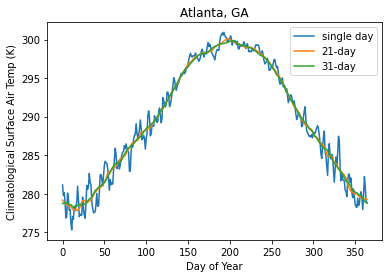

In [33]:
# Plot of Atlanta, GA climatology methods
# Rolling means taken after climo calc

x = range(0,365,1)

fig,ax = plt.subplots()

ax.plot(x, singleclimo_mean_AT, label='single day') # single day climo
ax.plot(x, climo_21runningmean_AT, label='21-day')
ax.plot(x, climo_31runningmean_AT, label='31-day')

plt.ylabel("Climatological Surface Air Temp (K)")
plt.xlabel("Day of Year")
plt.title("Atlanta, GA")

leg = ax.legend();

In [33]:
#DJF_climo

#np.squeeze(SL_climo[0]).shape

In [32]:
# 30-yr period climatologies

#singleclimo_mean = tas_noleap_all.sel(time=slice("1989-01-01", "1999-12-31")).groupby("dayofyear").mean().compute()
    

# singleclimo_1980_2009 = tas_noleap_all.sel(time=slice(thirtyyr_period_1980_2009[0], thirtyyr_period_1980_2009[1])).groupby("dayofyear").mean().compute()
# singleclimo_1989_2018 = tas_noleap_all.sel(time=slice(thirtyyr_period_1989_2018[0], thirtyyr_period_1989_2018[1])).groupby("dayofyear").mean().compute()
